In [1]:
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import datetime
import numpy as np

from scipy.stats import pearsonr

import os
import math

/home/ben/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Some auxiliary functions for working with pandas series

In [2]:
def date_from_datetime_series(datetime):
    return datetime.date()

In [3]:
def time_from_datetime_series(datetime):
    return datetime.time()

In [4]:
def parse_trends_timestamp(timestamp):
    datetime_str = timestamp.split(' ')
    return datetime.datetime.fromisoformat(datetime_str[0].split('/')[2]+'-'+datetime_str[0].split('/')[0]+'-'+datetime_str[0].split('/')[1]+ ' ' + datetime_str[1])

In [5]:
def parse_feedback_timestamp(timestamp):
    date_str = timestamp.split('T')[0]
    time_str = timestamp.split('T')[1]

    return datetime.datetime.fromisoformat(date_str + ' ' + time_str[:5])

### Loading Feedback data


In [6]:
feedback_room_df = pd.read_csv('../data/abschluss-daten/feedback_room.csv')
device_df = pd.read_csv('../data/abschluss-daten/device.csv')
participant_df = pd.read_csv('../data/abschluss-daten/participant.csv')

In [7]:

for column_name in device_df.columns:
    if 'timestamp' in column_name or 'At' in column_name:
        device_df[column_name] = device_df[column_name].dropna().apply(parse_feedback_timestamp)

for column_name in participant_df.columns:
    if 'timestamp' in column_name or 'At' in column_name:
        participant_df[column_name] = participant_df[column_name].dropna().apply(parse_feedback_timestamp)

for column_name in feedback_room_df.columns:
    if 'timestamp' in column_name or 'At' in column_name:
        feedback_room_df[column_name] = feedback_room_df[column_name].dropna().apply(datetime.datetime.fromisoformat)


### Loading Temperature & Air quality data

Loading data is done as a batch, a dataframe variable is created for each file with its name in the form rx_xx_df according to the file read.

In [8]:
dir_list = os.listdir('../data/Trends Smart City/0EG') + os.listdir('../data/Trends Smart City/1OG') + os.listdir('../data/Trends Smart City/2OG') + os.listdir('../data/Trends Smart City/3OG')

In [9]:
df_names = []

for filename in dir_list:
    split_name = filename.lower().split(' ')
    further_split_name = split_name[0].split('-')
    df_name = further_split_name[1]+'_'+further_split_name[2]

    if 'Lufttemp' in filename:
        df_name += '_temp_df'

    else:
        df_name += '_qual_df'

    #df_name = '_'.join(further_split_name[1:])+'_df'
    df_names.append(df_name)


    if further_split_name[1] == 'r0':
        globals()[df_name] = pd.read_csv('../data/Trends Smart City/0EG/'+filename,sep=';',header=0,usecols = [i for i in range(3)],names=['timestamp','value','reduced'])

    elif further_split_name[1] == 'r1':
        globals()[df_name] = pd.read_csv('../data/Trends Smart City/1OG/'+filename,sep=';',header=0,usecols = [i for i in range(3)],names=['timestamp','value','reduced'])

    elif further_split_name[1] == 'r2':
        globals()[df_name] = pd.read_csv('../data/Trends Smart City/2OG/'+filename,sep=';',header=0,usecols = [i for i in range(3)],names=['timestamp','value','reduced'])

    elif further_split_name[1] == 'r3':
        globals()[df_name] = pd.read_csv('../data/Trends Smart City/3OG/'+filename,sep=';',header=0,usecols = [i for i in range(3)],names=['timestamp','value','reduced'])

    globals()[df_name]['timestamp'] = globals()[df_name]['timestamp'].apply(parse_trends_timestamp)

Changing the room name format to match that used in the trends dataset

In [10]:
def parse_roomName(roomName):
    if 'VS' not in roomName:
        return

    roomName = roomName[3:]
    roomName = roomName.split('.')
    return 'r'+'_'.join(roomName)



In [11]:
feedback_room_df['roomName'] = feedback_room_df['roomName'].apply(parse_roomName)

### Splitting feedback data

In [12]:
daily_airDraft_df = feedback_room_df[['daily_airDraft_timestamp','daily_airDraft_value','roomName']].dropna()
daily_ambientSounds_df = feedback_room_df[['daily_ambientSounds_timestamp','daily_ambientSounds_value','roomName']].dropna()
daily_artificialLight_df = feedback_room_df[['daily_artificialLight_timestamp','daily_artificialLight_value','roomName']].dropna()
daily_dayLight_df = feedback_room_df[['daily_dayLight_timestamp','daily_dayLight_value','roomName']].dropna()
daily_smell_df = feedback_room_df[['daily_smell_timestamp','daily_smell_value','roomName']].dropna()
daily_studentsAdherence_df = feedback_room_df[['daily_studentsAdherence_timestamp', 'daily_studentsAdherence_value','roomName']].dropna()
daily_studentsFocused_df = feedback_room_df[['daily_studentsFocused_timestamp', 'daily_studentsFocused_value','roomName']].dropna()
daily_studentsIrritated_df = feedback_room_df[['daily_studentsIrritated_timestamp', 'daily_studentsIrritated_value','roomName']].dropna()
daily_studentsMotivated_df =feedback_room_df[['daily_studentsMotivated_timestamp', 'daily_studentsMotivated_value','roomName']].dropna()

hourly_airQuality_df = feedback_room_df[['hourly_airQuality_timestamp', 'hourly_airQuality_value','roomName']].dropna()
hourly_humidity_df = feedback_room_df[['hourly_humidity_timestamp', 'hourly_humidity_value','roomName']].dropna()
hourly_indoorClimate_df = feedback_room_df[['hourly_indoorClimate_timestamp', 'hourly_indoorClimate_value','roomName']].dropna()
hourly_temperature_df = feedback_room_df[['hourly_temperature_timestamp', 'hourly_temperature_value','roomName']].dropna()

In [13]:
daily_feedback_data = [daily_airDraft_df,daily_ambientSounds_df,daily_artificialLight_df,daily_dayLight_df,daily_smell_df,daily_studentsAdherence_df,daily_studentsFocused_df,daily_studentsIrritated_df,daily_studentsMotivated_df]

In [14]:
hourly_feedback_data = [hourly_airQuality_df,hourly_humidity_df,hourly_indoorClimate_df,hourly_temperature_df]

## Removing all daily feedback entries before classes would have occured that day

In [15]:
minimum_time = datetime.time(hour=8,minute=0) #8 am

In [16]:
for dataframe in daily_feedback_data:
    dataframe = dataframe[dataframe.iloc[:, 0] .apply(time_from_datetime_series) > minimum_time] 

## Plotting
Plotting scatterplots for values from feedback dataset against the max temp/qual reading from the room air data

Here only points for which we have the following are plotted: 
- Temp/Qual data for that particular room
- Points for which have have temp/qual data from the past hour for that room

Only a small percentage of the data points we have meets the above criteria therefore these plots might not be indicative of the actual data


^ Change the above to the daily room averages

3 is happiest

2 = 4

1 = 5

In [17]:
def get_daily_average_value(timestamp,room,type='temp'):
    """
    Arguments: time and room from the feedback dataset,
        type: "temp" or "qual"


    Returns: average from 7am until the time of feedback
    
    """
    #skip rooms for which we don't have files for
    if room+'_'+type+'_df' not in df_names:
        #print('No data for room')
        return np.nan

    #Loading room air data
    room_data = globals()[room+'_'+type+'_df'].sort_values(by='timestamp')

    #calculating daily average
    mask = ((room_data['timestamp'].apply(date_from_datetime_series) == timestamp.date()) & (room_data['timestamp'].apply(time_from_datetime_series) > datetime.time(hour=7)) & (room_data['timestamp'] < timestamp))
    room_data = room_data.loc[mask]

    #If no value for that day return None 
    if len(room_data['value']) == 0:
        #print("No data for day")
        return np.nan #no data

    #return mean daily value
    return room_data['value'].mean()


In [18]:
def get_avg_past_hour_value(timestamp,room,type='temp'):
    """
    Arguments: time and room from the feedback dataset,
        type: "temp" or "qual"
    """
    #skip rooms for which we don't have files for
    if room+'_'+type+'_df' not in df_names:
        #print(room)
        #print('No data for room')
        return np.nan

    #Loading room air data
    room_data = globals()[room+'_'+type+'_df'].sort_values(by='timestamp')

    #calculating daily average
    mask = (room_data['timestamp'] >= timestamp - datetime.timedelta(hours=1)) & (room_data['timestamp'] <= timestamp)
    room_data = room_data.loc[mask]
    
    
    #If no value for that day return None 
    if len(room_data['value']) == 0:
        #print("No data for day")
        return np.nan #no data

    #return mean daily value
    return room_data['value'].mean()


In [19]:
type_dict = {'temp':"temperature",'qual':"quality"}

In [20]:
def Jitter(values, jitter):
    n = len(values)
    return np.random.uniform(-jitter, +jitter, n) + values


In [21]:
plt.rcParams["figure.figsize"] = (7,7)

Spearman corr: 0.2216053461800239


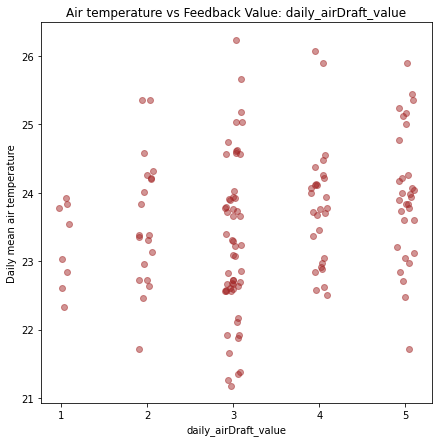

Spearman corr: -0.27024904079129713


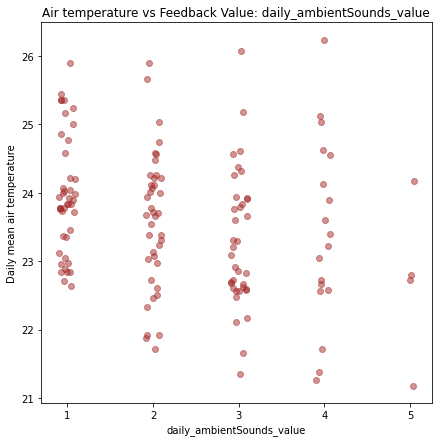

Spearman corr: -0.1471841535205209


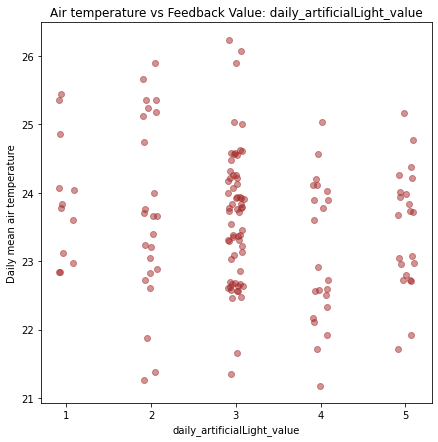

Spearman corr: -0.13998037740939615


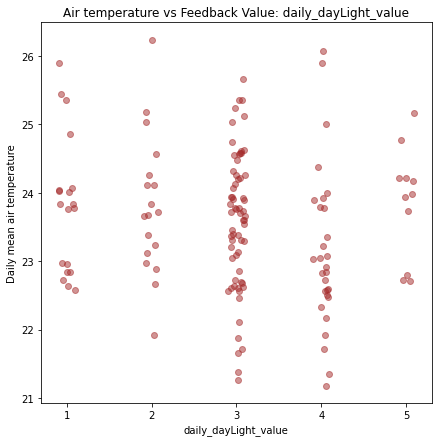

Spearman corr: -0.23478913656148925


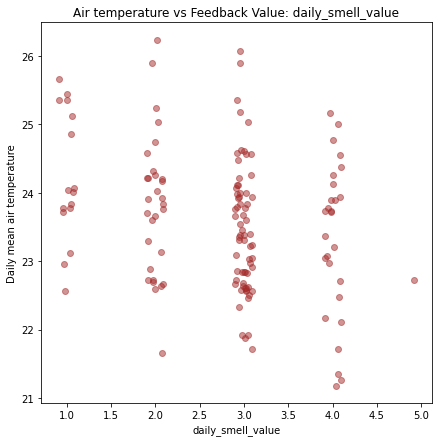

Spearman corr: -0.15078298608350152


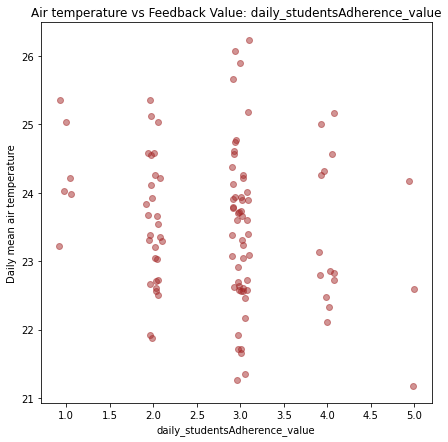

Spearman corr: -0.0694543017987142


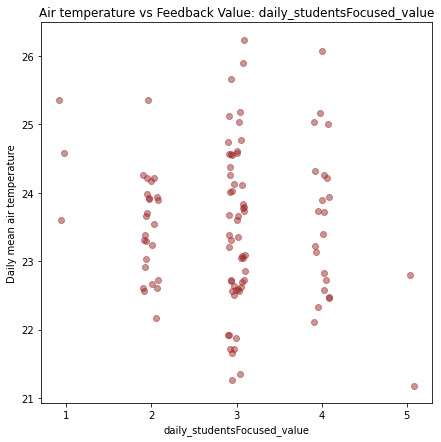

Spearman corr: -0.012183730027544852


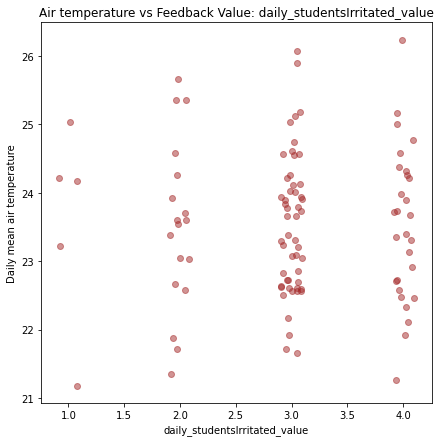

Spearman corr: -0.1838500950918647


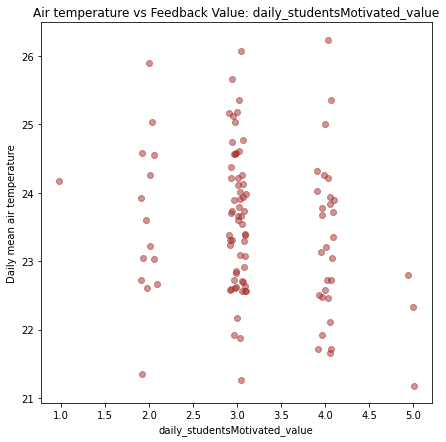

Spearman corr: 0.20987009416201685


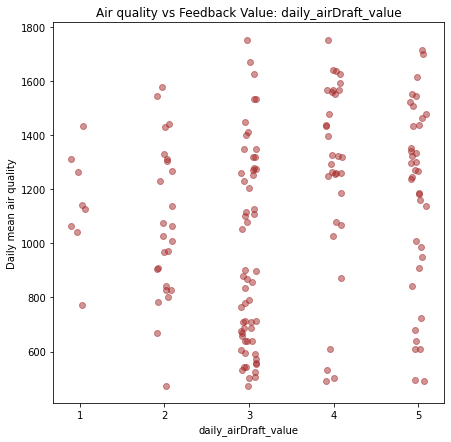

Spearman corr: -0.45684596815753625


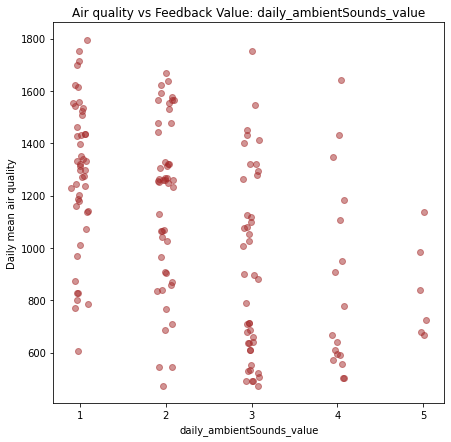

Spearman corr: -0.03746970474114282


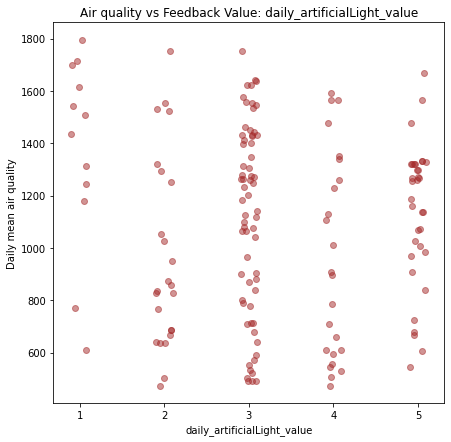

Spearman corr: -0.05800849269761918


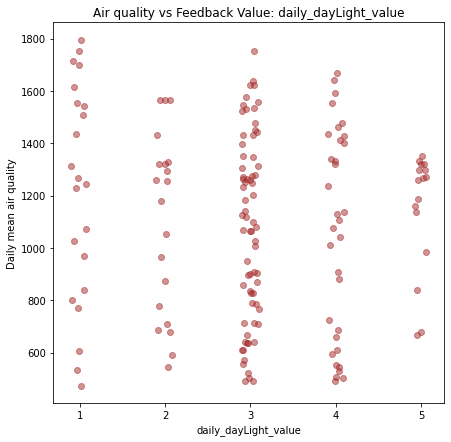

Spearman corr: -0.034660961522229396


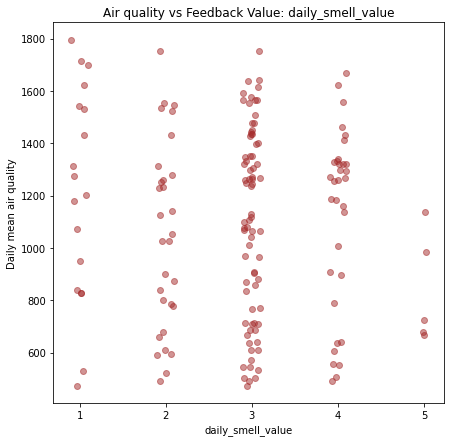

Spearman corr: -0.1275091793986335


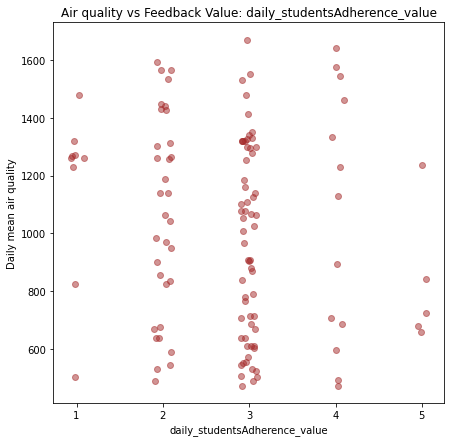

Spearman corr: 0.0803549094270071


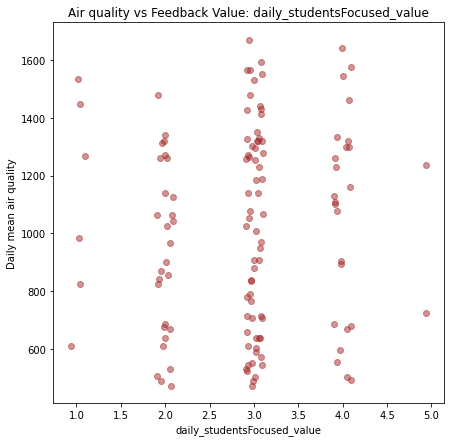

Spearman corr: 0.08905198051690562


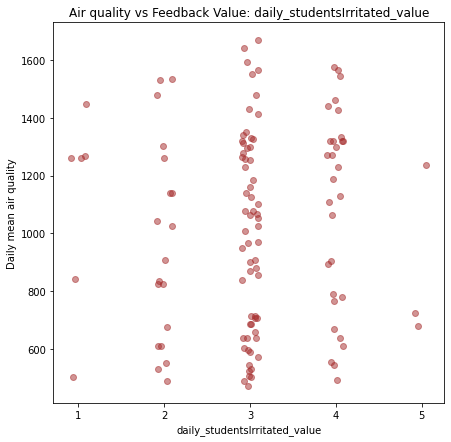

Spearman corr: 0.06283777735363913


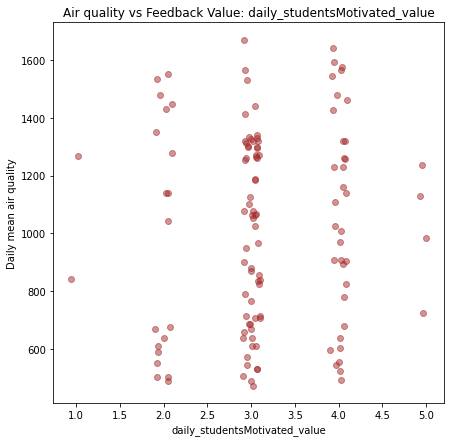

In [22]:
for type in ['temp','qual']:
    
    #for each feedback type
    for dataframe in [daily_airDraft_df,daily_ambientSounds_df,daily_artificialLight_df,daily_dayLight_df,daily_smell_df,daily_studentsAdherence_df,daily_studentsFocused_df,daily_studentsIrritated_df,daily_studentsMotivated_df]:
        #print(dataframe.columns)
        x = dataframe[dataframe.columns[1]] #feedback value
        y = []

        for timestamp, room in zip(dataframe[dataframe.columns[0]],dataframe[dataframe.columns[2]]): #0=timestamp, 2=roomName
            #max getting room air temp/qual for that room in the past hour
            y.append(get_daily_average_value(timestamp,room,type))

        plt.figure()
        plt.scatter(Jitter(x,0.1), y, alpha=0.5, color='brown')

        plt.title("Air "+type_dict[type] + " vs Feedback Value: "+ dataframe.columns[1])
 

        #dropping nan values and calculating correlation between x and y
        print("Spearman corr: "+str(pd.DataFrame({"x":x, 'y':y}).dropna().corr(method='spearman')['y']['x']))
        
        plt.xlabel(dataframe.columns[1])
        plt.ylabel("Daily mean air "+type_dict[type])
        
        plt.savefig("../plots/room_air_"+type+"/"+dataframe.columns[1]+".png")
        plt.show()




For our hourly data, a rating of 3 is the best, 2 and 4 slighty worse, 1 and 5 the worst

In [23]:
def make_3_best_score(score):
    if score == 3:
        return 3
    elif score == 2 or score == 4:
        return 2 #a slightly worse score
    elif score == 1 or score == 5:
        return 1 #a slightly worse score

Spearman corr: -0.1257326006567548


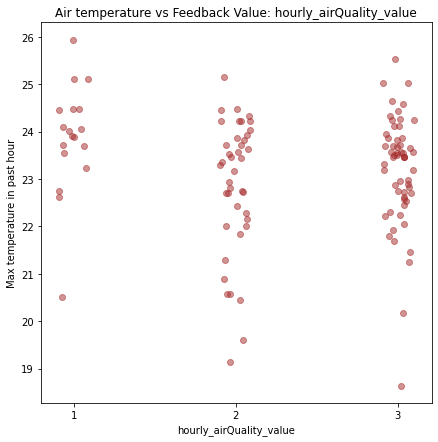

Spearman corr: -0.21424200149516268


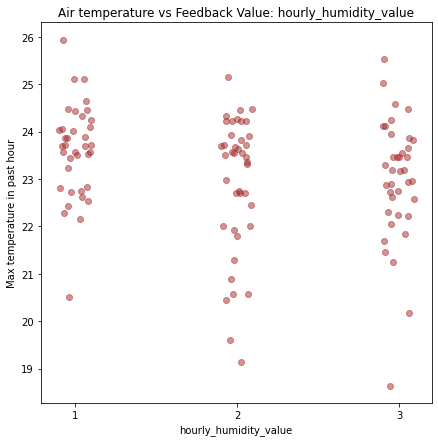

Spearman corr: -0.18917694579621908


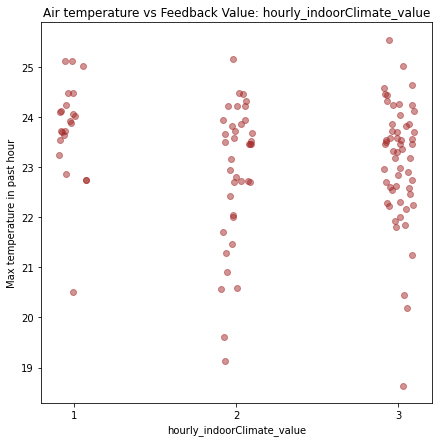

Spearman corr: -0.13084266655412446


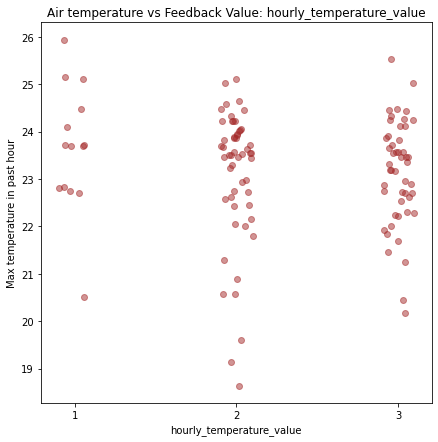

Spearman corr: -0.045644079067483107


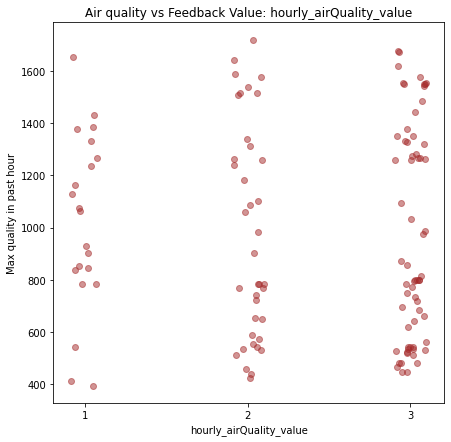

Spearman corr: -0.056081978922447026


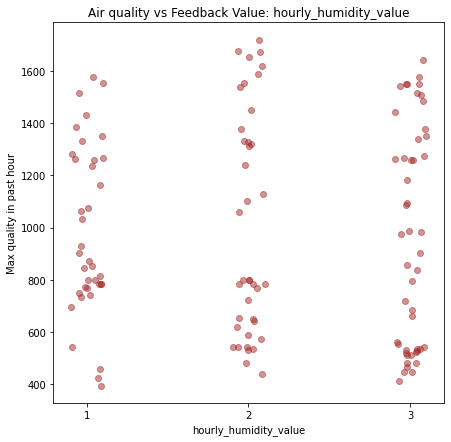

Spearman corr: -0.10313662530265155


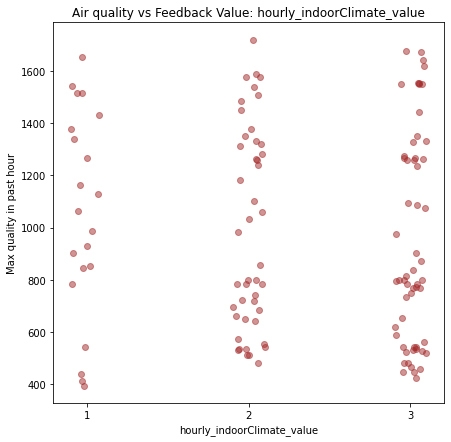

Spearman corr: -0.1521633558296801


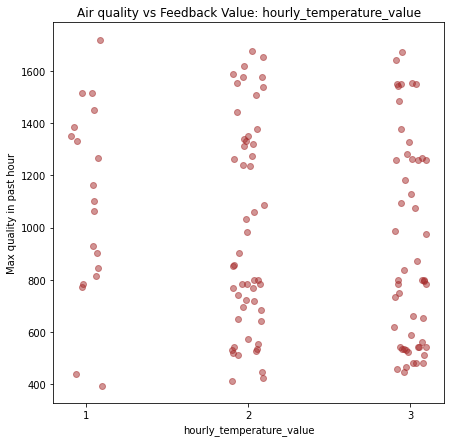

In [28]:
for type in ['temp','qual']:
    
    #for each feedback type
    for dataframe in [hourly_airQuality_df,hourly_humidity_df,hourly_indoorClimate_df,hourly_temperature_df]:

        #dataframe.columns[1] is the feedback value
        dataframe['new_value'] = dataframe.iloc[:,1].apply(make_3_best_score)
        #print(dataframe.columns)
        x = dataframe['new_value'] #feedback value
        y = []

        for timestamp, room in zip(dataframe[dataframe.columns[0]],dataframe[dataframe.columns[2]]): #0=timestamp, 2=roomName
            #getting mean air temp/qual for that room in the past hour
            y.append(get_avg_past_hour_value(timestamp,room,type))

        plt.figure()
        plt.scatter(Jitter(x,0.1), y, alpha=0.5, color='brown')

        plt.title("Air "+type_dict[type] +" vs Feedback Value: "+ dataframe.columns[1])#+ dataframe.columns[1])

        #dropping nan values and calculating correlation between x and y
        print("Spearman corr: "+str(pd.DataFrame({"x":x, 'y':y}).dropna().corr(method='spearman')['x']['y']))
        
        plt.xlabel(dataframe.columns[1])
        plt.xticks([1,2,3])

        plt.ylabel("Max "+type_dict[type]+ " in past hour")
        
        plt.savefig("../plots/room_air_"+type+"/"+dataframe.columns[1]+".png")
        plt.show()


Plotting trends sensor data against time

In [25]:
r0_qual_dfs = [globals()[df_name] for df_name in globals().keys() if 'r0' in df_name if 'qual' in df_name]
r0_temp_dfs = [globals()[df_name]  for df_name in globals().keys() if 'r0' in df_name if 'temp' in df_name]

r1_qual_dfs = [globals()[df_name]  for df_name in globals().keys() if 'r1' in df_name if 'qual' in df_name]
r1_temp_dfs = [globals()[df_name]  for df_name in globals().keys() if 'r1' in df_name if 'temp' in df_name]

r2_qual_dfs = [globals()[df_name]  for df_name in globals().keys() if 'r2' in df_name if 'qual' in df_name]
r2_temp_dfs = [globals()[df_name]  for df_name in globals().keys() if 'r2' in df_name if 'temp' in df_name]

r3_qual_dfs = [globals()[df_name]  for df_name in globals().keys() if 'r3' in df_name if 'qual' in df_name]
r3_temp_dfs = [globals()[df_name]  for df_name in globals().keys() if 'r3' in df_name if 'temp' in df_name]

/home/ben/.local/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


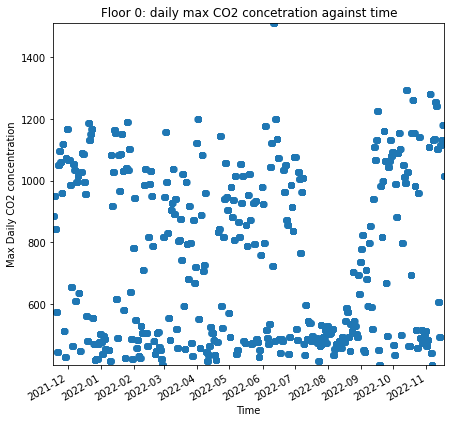

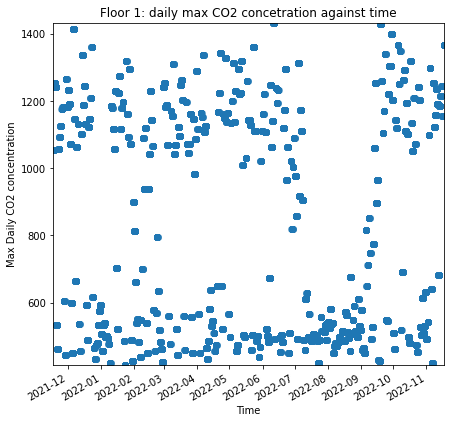

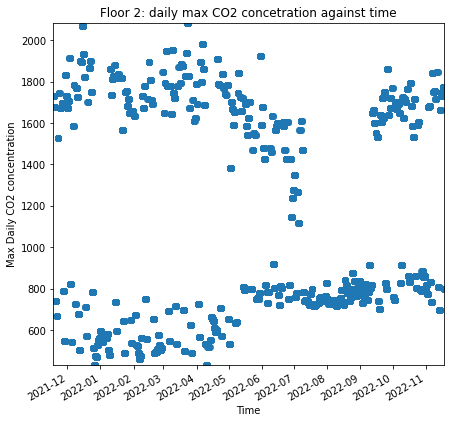

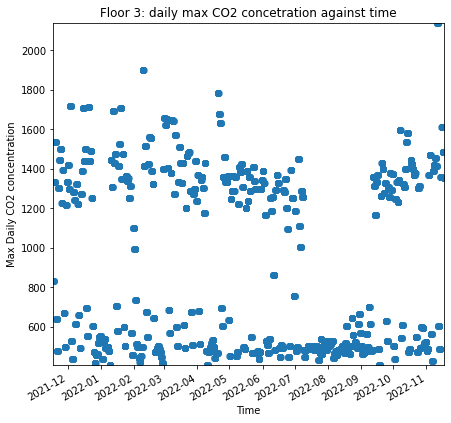

In [26]:
floor_num = 0
for floor_data in [r0_qual_dfs,r1_qual_dfs,r2_qual_dfs,r3_qual_dfs]:

    #Finding the daily max CO2 level in each floor
    qualdata = pd.concat(floor_data, axis = 0)
    qualdata['date'] = qualdata['timestamp'].dt.date
    qualdata['DayMax'] = qualdata.groupby(qualdata['date'])['value'].transform('max')

    #considering only one reading per day
    qualdata.drop_duplicates(subset='date', keep="first") 
    #print(qualdata)

    #plotting floor max co2 against time
    plt.scatter(qualdata['timestamp'], qualdata['DayMax'], alpha=0.5)
    plt.gca().xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
    plt.gcf().autofmt_xdate()
    plt.margins(x=0,y=0)
    plt.title("Floor " + str(floor_num) + ": daily max CO2 concetration against time")
    plt.ylabel("Max Daily CO2 concentration")
    plt.xlabel("Time")
    plt.savefig('../plots/floor_qual/floor_'+str(floor_num)+".png")
    plt.show()

    floor_num +=1


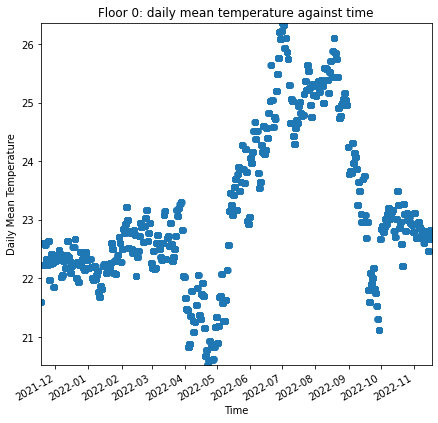

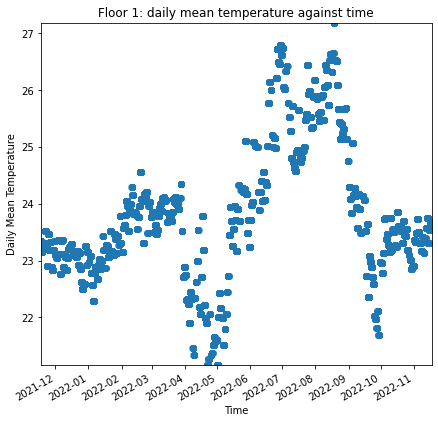

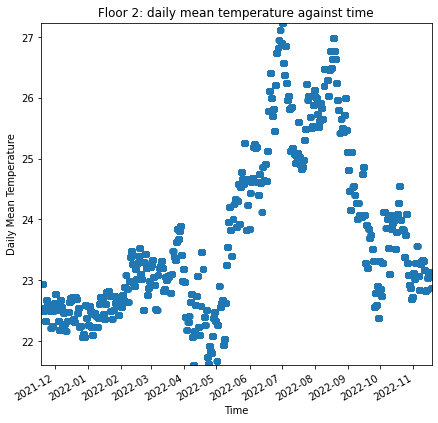

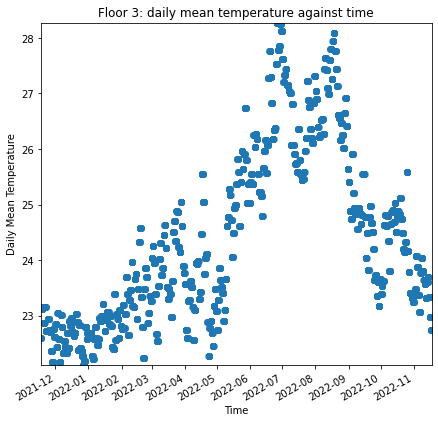

In [27]:
floor_num = 0
for floor_data in [r0_temp_dfs,r1_temp_dfs,r2_temp_dfs,r3_temp_dfs]:

    #Finding the daily max temp level in each floor
    tempdata = pd.concat(floor_data, axis = 0)
    tempdata['date'] = tempdata['timestamp'].dt.date
    tempdata['DayMax'] = tempdata.groupby(tempdata['date'])['value'].transform('mean')

    #considering only one reading per day
    tempdata.drop_duplicates(subset='date', keep="first") 
    #print(tempdata)

    #plotting floor max temp against time
    plt.scatter(tempdata['timestamp'], tempdata['DayMax'], alpha=0.5)
    plt.gca().xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
    plt.gcf().autofmt_xdate()
    plt.margins(x=0,y=0)
    plt.title("Floor " + str(floor_num) + ": daily mean temperature against time")
    plt.ylabel("Daily Mean Temperature")
    plt.xlabel("Time")
    plt.savefig('../plots/floor_temp/floor_'+str(floor_num)+".png")
    plt.show()

    floor_num +=1
